In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
from __future__ import print_function
from __future__ import division
from sklearn import preprocessing
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from torchvision import models,transforms, datasets
import datetime
import pickle
import copy
import requests
import shutil
import cv2
# from model import *

In [67]:
def audio_input(audio_directory, sr=44100):
    '''
    Takes in a directory of audio files and returns a list of audio arrays

    Parameters:
    -----------
    audio_directory: str, path to audio directory
    
    Returns:
    --------
    Tuple: samples: (np.ndarray, shape = (N,), 
                    sampling_rate: int)
    '''
    samples, sampling_rate = librosa.load(path = audio_directory, sr=sr, mono=True)
    return samples, sampling_rate

def slice_audio(audio_array, sampling_rate, slice_len):
    """
    Parameters:
    -----------
    audio_array: np.ndarray, shape = (N,)
    sampling_rate: int
    slice_len: int
        The desired length of sliced clips in seconds
    Returns:
    -----------
    slices: list of np.ndarrays, each representing a slice_len clip 
    """
    slices = []
    audio_array_list = list(audio_array)
    audio_array2 = audio_array_list
    # 5 * (41000 * t) / 41000
    # 54 * 41000 % (5 * 41000) = 9 * 41000
    # 54 * 41000 += 41000 * 5 - 
    # print("here2", (sampling_rate * slice_len))
    if len(audio_array2) < (sampling_rate * slice_len):
        while len(audio_array2) < (sampling_rate * slice_len):
            # print("here", len(audio_array2)) # 41000 * 3
            
            # print(audio_array.shape[0])
            # print("here2", sampling_rate * slice_len - audio_array.shape[0])
            # print("extra", len(audio_array2) % (sampling_rate * slice_len))
            # 41000 * 3 + 41000 * 5 - 41000 * 3
            # print(audio_array.shape)
            audio_array2 += audio_array_list
        audio_array2 += audio_array_list[:sampling_rate * slice_len % audio_array.shape[0]]
    else:
        audio_array2 += audio_array_list[:audio_array.shape[0] % sampling_rate]

    # print("len: ", len(audio_array2), len(audio_array2) / sampling_rate)
    for clip in range(len(audio_array2)//(sampling_rate * slice_len)):
        
        arr = audio_array2[sampling_rate*slice_len*clip:sampling_rate*slice_len*(clip+1)]
        # print("len, arr", len(arr))
        slices.append(np.array(arr))
    # print(len(slices))
    return slices

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    # device = torch.device("cuda")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    train_accuracies = [0]
    val_losses = []
    val_accuracies = [0]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                # print("appending train", epoch, epoch_loss)
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else: 
                # print("appending test", epoch, epoch_loss)
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plot loss and accuracy graphs
    
    return model, val_acc_history, (train_losses, train_accuracies, val_losses, val_accuracies)

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

In [101]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
root = "gdrive/MyDrive/Cogfee Beans"
data_dir = "gdrive/MyDrive/Cogfee Beans/train_val_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = len(os.listdir(data_dir + "/train"))
print(num_classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for
num_epochs = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes,feature_extract=feature_extract, use_pretrained=True)
# Data augmentation and normalization for training
# Just normalization for validation
from torchvision.datasets import DatasetFolder
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}
print("Initializing Datasets and Dataloaders...")

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available


# Send the model to GPU
# model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Trainer
model_ft, hist, detailed_hist = train_model(model_ft, 
                                            dataloaders_dict, 
                                            criterion, optimizer_ft, 
                                            num_epochs=num_epochs, 
                                            is_inception=False)
train_losses, train_accuracies, val_losses, val_accuracies = detailed_hist

3


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing Datasets and Dataloaders...
Initializing Datasets and Dataloaders...
Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0019 Acc: 0.5046
val Loss: 1.1297 Acc: 0.3590

Epoch 1/9
----------
train Loss: 0.6757 Acc: 0.7645
val Loss: 0.9866 Acc: 0.3846

Epoch 2/9
----------
train Loss: 0.5745 Acc: 0.7737
val Loss: 0.5756 Acc: 0.8205

Epoch 3/9
----------
train Loss: 0.5354 Acc: 0.8012
val Loss: 0.4620 Acc: 0.8333

Epoch 4/9
----------
train Loss: 0.4536 Acc: 0.8226
val Loss: 0.4167 Acc: 0.8333

Epoch 5/9
----------
train Loss: 0.4362 Acc: 0.8379
val Loss: 0.3962 Acc: 0.8333

Epoch 6/9
----------
train Loss: 0.3994 Acc: 0.8349
val Loss: 0.3972 Acc: 0.8718

Epoch 7/9
----------
train Loss: 0.3807 Acc: 0.8379
val Loss: 0.3745 Acc: 0.8590

Epoch 8/9
----------
train Loss: 0.3693 Acc: 0.8502
val Loss: 0.3732 Acc: 0.8590

Epoch 9/9
----------
train Loss: 0.4173 Acc: 0.8349
val Loss: 0.3637 Acc: 0.8718

Training complete in 6m 0s
Best val Acc: 0.871795


In [102]:
train_accuracies[-1]

tensor(0.8349, dtype=torch.float64)

In [103]:
print(train_losses,"\n", train_accuracies, "\n", val_losses, "\n", val_accuracies)

[1.0018648776803907, 0.6756995901784401, 0.5744974145648676, 0.5353997732521197, 0.45361717824542197, 0.436157323533971, 0.3993789225543311, 0.38070015404202523, 0.36934993810245387, 0.4172742772357544] 
 [0, tensor(0.5046, dtype=torch.float64), tensor(0.7645, dtype=torch.float64), tensor(0.7737, dtype=torch.float64), tensor(0.8012, dtype=torch.float64), tensor(0.8226, dtype=torch.float64), tensor(0.8379, dtype=torch.float64), tensor(0.8349, dtype=torch.float64), tensor(0.8379, dtype=torch.float64), tensor(0.8502, dtype=torch.float64), tensor(0.8349, dtype=torch.float64)] 
 [1.12974559649443, 0.9865745306015015, 0.5756258933972089, 0.4619506421761635, 0.41674516445551163, 0.39615251697026765, 0.3972329665453006, 0.3745125165352455, 0.3732153643400241, 0.36372246879797715] 
 [0, tensor(0.3590, dtype=torch.float64), tensor(0.3846, dtype=torch.float64), tensor(0.8205, dtype=torch.float64), tensor(0.8333, dtype=torch.float64), tensor(0.8333, dtype=torch.float64), tensor(0.8333, dtype=torch

In [104]:
np.arange(1, len(train_losses) + 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

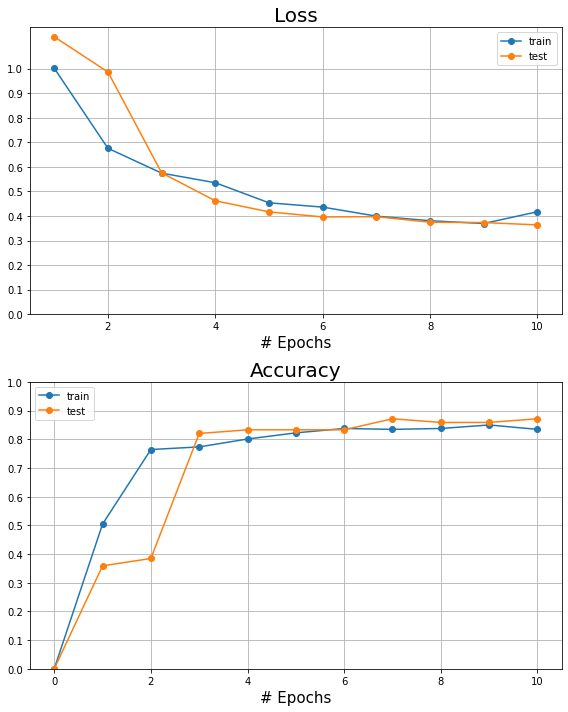

In [105]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, figsize=(8,10))
# print("train_losses", train_losses)
ax[0].plot(np.arange(1, len(train_losses) + 1), train_losses, label="train", marker="o")
ax[0].plot(np.arange(1, len(val_losses) + 1), val_losses, label="test", marker="o")
ax[0].set_xlabel("# Epochs", fontsize=15)
ax[0].set_title("Loss", fontsize=20)
ax[0].set_ylim(0)
ax[0].set_yticks(np.arange(0,11) / 10)
ax[1].plot(np.arange(len(train_accuracies)), train_accuracies, label="train", marker="o")
ax[1].plot(np.arange(len(val_accuracies)), val_accuracies, label="test", marker="o")
ax[1].set_xlabel("# Epochs", fontsize=15)
ax[1].set_title("Accuracy", fontsize=20)
ax[1].set_ylim(0, 1)
ax[1].set_yticks(np.arange(0,11) / 10)
ax[0].legend()
ax[1].legend()
fig.tight_layout()
ax[0].grid()
ax[1].grid()
plt.show()

In [ ]:
hist

In [106]:
# save model

print(type(model_ft))
torch.save(model_ft.state_dict(), root + "/audio_models/model4.pt")

<class 'torchvision.models.resnet.ResNet'>


In [3]:
num_classes = 3
root = "drive/MyDrive/Cogfee Beans"
data_dir = "drive/MyDrive/Cogfee Beans/train_val_data"
model = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model, feature_extract)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(root + "/audio_models/model4.pt"))
# model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [14]:
input_size = 224
from torchvision.datasets import DatasetFolder
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=26 * 3, shuffle=True, num_workers=4) for x in ['train', 'val']}
image_datasets['train'].class_to_idx

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'dolphin': 0, 'seal': 1, 'whale': 2}

In [11]:
from PIL import Image

In [15]:
model.eval()   # Set model to evaluate mode

# Iterate over data.
for inputs, labels in dataloaders['val']:
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
preds

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1, 2,
        0, 1, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0,
        1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 1, 1,
        2, 1, 0, 2, 1, 2])

In [17]:
sum(preds == labels) / len(preds)
# root

tensor(0.8718)

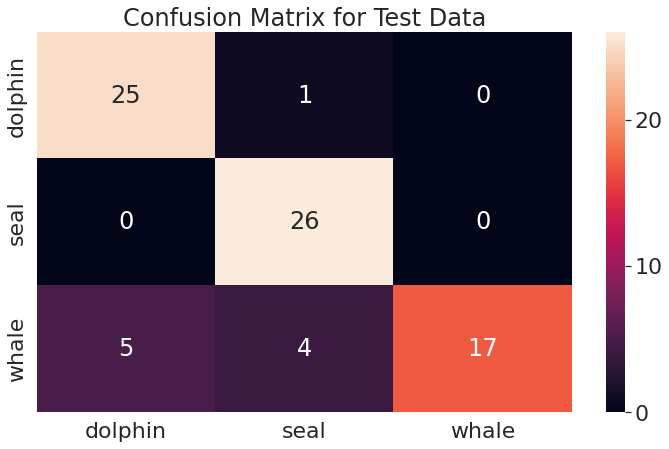

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ['dolphin', 'seal', 'whale']

# Build confusion matrix
cf_matrix = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Confusion Matrix for Test Data")
sn.heatmap(df_cm, annot=True, fmt='d')
sn.set(font_scale=5)
plt.savefig(root + '/audio_models/confusion_matrix_test.jpg')
# plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


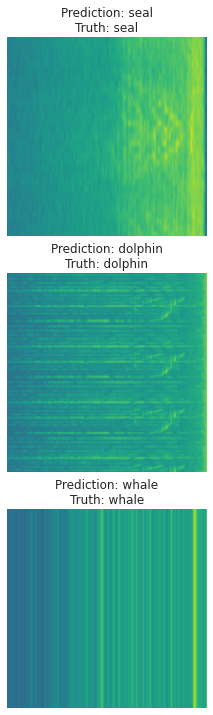

In [85]:
sn.set(font_scale=1)
class_to_idx = image_datasets['train'].class_to_idx
idx_to_class = dict((v,k) for k,v in class_to_idx.items())

num_plots = 3
fig, ax = plt.subplots(num_plots, figsize=(10, 10))
fig.tight_layout()
# plt.grid(False)
# plt.axis('off')
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        for num, img_array in enumerate(inputs):
            if num > (num_plots - 1):
                break
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                # print(img_array.shape)
                outputs = model(img_array.unsqueeze(0))
                _, preds = torch.max(outputs, 1)
            label = labels[num]
            # print("Prediction: " + idx_to_class[int(preds)] + ", Truth: " + idx_to_class[int(label)])
            ax[num].grid(False)
            ax[num].axis('off')
            ax[num].set_title("Prediction: " + idx_to_class[int(preds)] + "\nTruth: " + idx_to_class[int(label)])
            ax[num].imshow(img_array.T) # Note: the images are sideways. Didn't have time to fix this

In [28]:
test_dir = data_dir + "/val"
with torch.no_grad():
    for animal in os.listdir(test_dir):
        animal_dir = test_dir + f"/{animal}"
        # print(os.listdir(animal_dir))
        for num, imgname in enumerate(list(os.listdir(animal_dir))[::-1]):
            if num > 2:
                break
            # img = cv2.imread(f"{animal_dir}/{imgname}")
            # print(img.shape)
            # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # img = cv2.resize(img,(224,224))
            # img1 = img.transpose(2,0,1)
            # img1 = torch.tensor(img1,dtype=torch.float32) / 255.0
            # img1 = img1.unsqueeze(0)  # if torch tensor
            img = Image.open(animal_dir + "/" + imgname) 
           
            img = data_transforms['val'](img).squeeze(0)
            print(img[3])
            print(img.shape)
            pred = model(img) 
            pred_class = np.argmax(pred)
            plt.imshow(img)
            class_to_idx = image_datasets['train'].class_to_idx
            idx_to_class = dict((v,k) for k,v in class_to_idx.items())
            pred_class = idx_to_class[int(pred_class)]
            true_class = animal
            print("Prediction", pred_class)
            print("Truth", true_class)
            # plt.title(f'Prediction: {class2idx[int(pred_class)]} - Actual target: {true_target}')
            plt.show()

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
torch.Size([4, 224, 224])


RuntimeError: ignored

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4) for x in ['train', 'val']}
criterion = nn.CrossEntropyLoss()
running_corrects = 0
for inputs, labels in dataloaders["val"]:
    # forward
    # track history if only in train
    predictions = []
    truth = []
    with torch.set_grad_enabled(False):
        # Get model outputs and calculate loss
        # Special case for inception because in training it has an auxiliary output. In train
        #   mode we calculate the loss by summing the final output and the auxiliary output
        #   but in testing we only consider the final output.
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        # print(torch.sum(preds == labels.data) / len(preds))
        print(preds.tolist())
        print(labels.tolist())
        # pred_class = idx_to_class[int(preds)]
        # true_class = animal
        # plt.title(f"Prediction: {pred_class}, Truth: {true_class}")
        # plt.imshow(inputs.data.squeeze().T)
    # # statistics
    # running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
running_corrects / (26 * 3) # overall accuracy

In [ ]:
len(dataloaders['val'])

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
root = "gdrive/MyDrive/Cogfee Beans"
data_dir = "gdrive/MyDrive/Cogfee Beans/train_val_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = len(os.listdir(data_dir + "/train"))
print(num_classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for
num_epochs = 10
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

model_ft, input_size = initialize_model(model_name, num_classes,feature_extract=feature_extract, use_pretrained=True)
# Data augmentation and normalization for training
# Just normalization for validation
from torchvision.datasets import DatasetFolder
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(input_size),
        # transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ]),
}
print("Initializing Datasets and Dataloaders...")

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available


# Send the model to GPU
# model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Trainer
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
print(type(model_ft))
torch.save(model_ft.state_dict(), root + "/audio_models/model2.pt")